**GPU Info**

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


**CPU Info**

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


**Package Installs And Imports**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path
import PIL
import PIL.Image
from random import randint

In [ ]:
from google.colab import files
import zipfile
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Upload the zip file manually
uploaded = files.upload()

# After upload, get the filename
for filename in uploaded.keys():
    zip_path = filename  # Should be 'Cloud_Dataset.zip'

# Unzip it
extract_path = 'cloud_dataset_unzipped'
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction completed.")

# Load the dataset
dataset_dir = os.path.join(extract_path, 'CCSN_v2')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root=dataset_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

print(f"Number of images: {len(dataset)}")
print(f"Classes: {dataset.classes}")

**Classes**

In [ ]:
class_names = dataset.classes
num_classes = len(class_names)
print(num_classes)
print(class_names)

11
['Ac', 'As', 'Cb', 'Cc', 'Ci', 'Cs', 'Ct', 'Cu', 'Ns', 'Sc', 'St']


**Samples From Dataset**

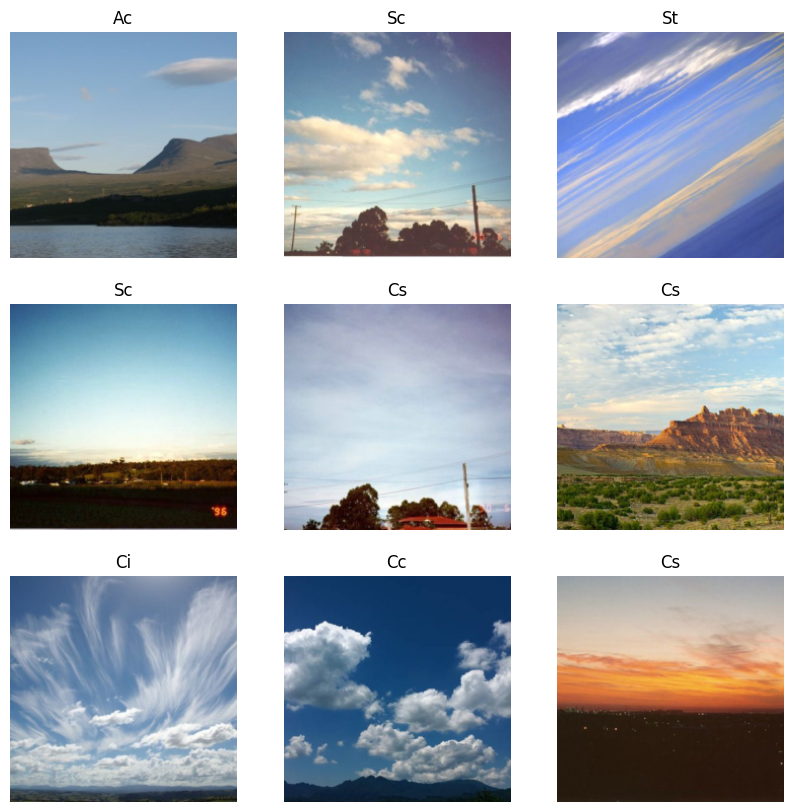

In [ ]:
import matplotlib.pyplot as plt
import torch

# First, get one batch from the dataloader
images, labels = next(iter(dataloader))

# Plot 9 sample images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    # Images are (C, H, W) in PyTorch — need to transpose to (H, W, C) for plotting
    img = images[i].permute(1, 2, 0)  # (H, W, C)
    plt.imshow(img.numpy())
    plt.title(class_names[labels[i]])
    plt.axis("off")

plt.show()

**Prepare Train/Validation/Test Datasets**

In [ ]:
from torch.utils.data import random_split

# Define the function for splitting the dataset
def get_dataset_partitions_pd(dataset, ds_size, train_split=0.7, val_split=0.2, test_split=0.1):
    assert (train_split + val_split + test_split) == 1, "Splits must sum to 1"

    # Calculate sizes for each split
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    test_size = ds_size - train_size - val_size  # Remaining for test

    # Randomly split the dataset
    train_ds, val_ds, test_ds = random_split(
        dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)  # Ensure reproducibility
    )

    return train_ds, val_ds, test_ds

**Setting Prefetch**

In [ ]:
import math
from torch.utils.data import random_split

# Define the function for splitting the dataset
def get_dataset_partitions_pd(dataset, ds_size, train_split=0.7, val_split=0.2, test_split=0.1):
    splits_sum = train_split + val_split + test_split
    print(f"Total sum of splits: {splits_sum}")  # Debugging line

    # Check if the sum is close to 1.0, allowing small floating-point errors
    if not math.isclose(splits_sum, 1.0, rel_tol=1e-9):  # Relative tolerance of 1e-9
        raise AssertionError(f"Splits must sum to 1, but got: {splits_sum}")

    # Calculate sizes for each split
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    test_size = ds_size - train_size - val_size  # Remaining for test

    # Randomly split the dataset
    train_ds, val_ds, test_ds = random_split(
        dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)  # Ensure reproducibility
    )

    return train_ds, val_ds, test_ds

# Example usage:
train_ds, val_ds, test_ds = get_dataset_partitions_pd(dataset, ds_size=len(dataset))

# Now you can use `train_ds`, `val_ds`, and `test_ds`
print('Size of training dataset: %d' % len(train_ds))
print('Size of validation dataset: %d' % len(val_ds))
print('Size of test dataset: %d' % len(test_ds))


Total sum of splits: 0.9999999999999999
Size of training dataset: 1780
Size of validation dataset: 508
Size of test dataset: 255


**Data Augmentation**

In [ ]:
from torchvision import transforms

# Define the data augmentation pipeline
data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(20),  # Random rotation by 20 degrees
    transforms.ColorJitter(contrast=0.2),  # Random contrast adjustment (similar to RandomContrast)
])

Samples From Data Augmentation

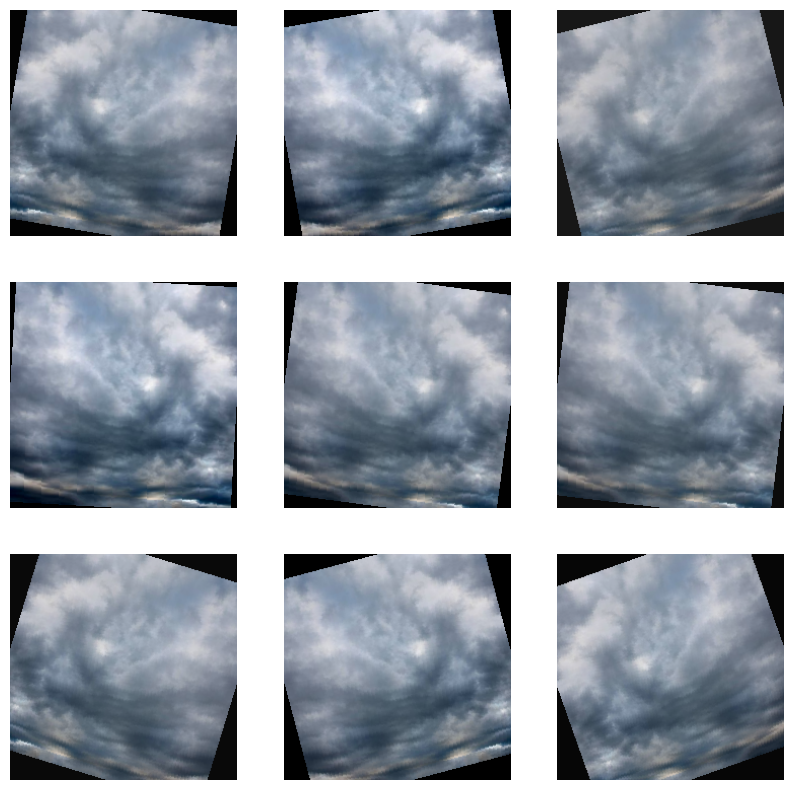

In [ ]:
from torchvision.utils import make_grid

image, _ = train_ds[0]  # Extract the first image (C, H, W)

# Apply the augmentation to the first image multiple times
augmented_images = [data_augmentation(image) for _ in range(9)]  # Create a list of augmented images

# Visualize the augmented images
plt.figure(figsize=(10, 10))
for i, augmented_image in enumerate(augmented_images):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image.permute(1, 2, 0))  # Convert (C, H, W) to (H, W, C) for plotting
    plt.axis('off')

plt.show()

**Fetching ResNet18 Pre-Trained Model**

In [ ]:
import torchvision.models as models
IMG_SIZE = 224  # Modify this according to your needs
IMG_SHAPE = (3, IMG_SIZE, IMG_SIZE)  # (C, H, W) for PyTorch

# Load the pre-trained ResNet model
base_model = models.resnet18(pretrained=True)

# Set the model to evaluation mode (important for inference)
base_model.eval()

# Example input tensor (a batch of images with shape [batch_size, C, H, W])
# For testing, we'll use a random tensor
input_tensor = torch.randn(1, 3, IMG_SIZE, IMG_SIZE)  # A batch of 1 image

# Pass the input through the model
output = base_model(input_tensor)

print(output.shape)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 86.6MB/s]


torch.Size([1, 1000])


**Shapes Of Features Extracted**

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define the image transformation for data loading
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Resize images
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

# Replace 'cloud_dataset_unzipped/CCSN_v2' with the correct path to your training dataset
train_ds = datasets.ImageFolder(root='cloud_dataset_unzipped/CCSN_v2', transform=transform)

# Create DataLoader for batching
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

# Load the pre-trained ResNet model
base_model = models.convnext_small(pretrained=True)
base_model.eval()  # Set to evaluation mode

# Get a batch from the DataLoader
image_batch, label_batch = next(iter(train_loader))  # Get a batch of images and labels

# Pass the image batch through the Resnet model
with torch.no_grad():  # Disable gradient tracking for inference
    feature_batch = base_model.features(image_batch)  # Use the feature extractor part

# Check the shape of the feature batch (it will have shape [batch_size, num_features, H, W])
print(feature_batch.shape)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Small_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_small-0c510722.pth" to /root/.cache/torch/hub/checkpoints/convnext_small-0c510722.pth
100%|██████████| 192M/192M [00:01<00:00, 123MB/s]


torch.Size([32, 768, 7, 7])


Trainable Variables

In [ ]:
# Assuming 'base_model' is your PyTorch Resnet model
total_trainable_params = sum(p.numel() for p in base_model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {total_trainable_params}")

Number of trainable parameters: 50223688


**Freezeout Fine Tuning**

In [ ]:
# Let's take a look to see how many layers are in the base model's features
base_layer_count = len(list(base_model.features.children()))
print("Number of layers in the base model's features: ", base_layer_count)

# Fine-tune from this layer onwards
fine_tune_at = int(base_layer_count * (1 / 3))

# Freeze all the layers before the `fine_tune_at` layer
for i, layer in enumerate(base_model.features.children()):
  if i < fine_tune_at:
    for param in layer.parameters():
      param.requires_grad = False

Number of layers in the base model's features:  8


In [ ]:
# Assuming 'base_model' is your PyTorch Resnet model
len([p for p in base_model.parameters() if p.requires_grad])

313

Base Model Summary

In [ ]:
import torchvision.models as models
from torchsummary import summary

# Assuming 'base_model' is your PyTorch ResNet model
# and IMG_SHAPE is defined as (3, IMG_SIZE, IMG_SIZE)

# Determine the device string ('cuda' or 'cpu')
device_str = 'cuda' if torch.cuda.is_available() else 'cpu'

# Move the model to the appropriate device
if device_str == 'cuda':
    base_model.to(device_str)

# Pass the device string to the summary function
summary(base_model, IMG_SHAPE, device=device_str)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 56, 56]           4,704
       LayerNorm2d-2           [-1, 96, 56, 56]             192
            Conv2d-3           [-1, 96, 56, 56]           4,800
           Permute-4           [-1, 56, 56, 96]               0
         LayerNorm-5           [-1, 56, 56, 96]             192
            Linear-6          [-1, 56, 56, 384]          37,248
              GELU-7          [-1, 56, 56, 384]               0
            Linear-8           [-1, 56, 56, 96]          36,960
           Permute-9           [-1, 96, 56, 56]               0
  StochasticDepth-10           [-1, 96, 56, 56]               0
          CNBlock-11           [-1, 96, 56, 56]               0
           Conv2d-12           [-1, 96, 56, 56]           4,800
          Permute-13           [-1, 56, 56, 96]               0
        LayerNorm-14           [-1, 56,

Pooling Layer

In [ ]:
import torch.nn as nn

# Define the global average pooling layer
global_average_layer = nn.AdaptiveAvgPool2d((1, 1))

# Apply it to the feature batch
feature_batch_average = global_average_layer(feature_batch)

# Flatten the output (batch_size, features)
feature_batch_average = torch.flatten(feature_batch_average, 1)

print(feature_batch_average.shape)


torch.Size([32, 768])


Prediction Layer

In [ ]:
import torch.nn as nn

# Define the prediction (classification) layer
prediction_layer = nn.Linear(feature_batch_average.shape[1], num_classes)

# Apply the layer to get predictions
prediction_batch = prediction_layer(feature_batch_average)

# Apply softmax activation
prediction_batch = torch.softmax(prediction_batch, dim=1)

print(prediction_batch.shape)

torch.Size([32, 11])


Building The Main Model Layers

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as T

class CloudClassifier(nn.Module):
    def __init__(self, base_model, num_classes):
        super(CloudClassifier, self).__init__()

        self.data_augmentation = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomRotation(20),
            T.ColorJitter(contrast=(0.2, 0.5))
        ])

        self.base_model = base_model
        self.global_average_layer = nn.AdaptiveAvgPool2d((1, 1))
        self.prediction_layer = nn.Linear(base_model.num_features, num_classes)
        self.softmax = nn.Softmax(dim=1)
        self.base_model.trainable = True

    def forward(self, x):
        x = self.data_augmentation(x)
        x = self.base_model(x)
        x = self.global_average_layer(x)
        x = torch.flatten(x, 1)
        x = self.prediction_layer(x)
        x = self.softmax(x)
        return x

Compiling The Main Model

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
import torch
import torchmetrics
from torchmetrics.classification import MulticlassPrecision, MulticlassRecall, MulticlassAUROC, MulticlassConfusionMatrix

def build_metrics(no_of_classes):
    metrics = {}

    # Overall accuracy
    metrics['accuracy'] = torchmetrics.classification.MulticlassAccuracy(num_classes=no_of_classes)

    # Per-class precision
    metrics['precision'] = MulticlassPrecision(num_classes=no_of_classes, average=None)

    # Per-class recall
    metrics['recall'] = MulticlassRecall(num_classes=no_of_classes, average=None)

    # ROC AUC
    metrics['roc_auc'] = MulticlassAUROC(num_classes=no_of_classes)

    # Confusion Matrix
    metrics['confusion_matrix'] = MulticlassConfusionMatrix(num_classes=no_of_classes)

    return metrics

In [ ]:
metrics = build_metrics(num_classes)

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as T

class CloudClassifier(nn.Module):
    def __init__(self, base_model, num_classes):
        super(CloudClassifier, self).__init__()

        self.data_augmentation = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomRotation(20),
            T.ColorJitter(contrast=(0.2, 0.5))
        ])

        self.base_model = base_model
        self.global_average_layer = nn.AdaptiveAvgPool2d((1, 1))
        # Accessing the number of features from the classifier head
        self.prediction_layer = nn.Linear(base_model.classifier[2].in_features, num_classes)
        self.softmax = nn.Softmax(dim=1)
        self.base_model.trainable = True

    def forward(self, x):
        x = self.data_augmentation(x)
        x = self.base_model.features(x) # Extract features before the classifier head
        x = self.global_average_layer(x)
        x = torch.flatten(x, 1)
        x = self.prediction_layer(x)
        x = self.softmax(x)
        return x

Check The Main Model's Accuracy Before Training

In [ ]:
def get_precision_evaluation(history):
  precision = 0.0
  precision_begin = 2
  precision_end = precision_begin + num_classes
  for i in range(precision_begin, precision_end):
    precision += history[i]

  return precision / num_classes

def get_recall_evaluation(history):
  recall = 0.0
  recall_begin = 2 + num_classes
  recall_end = recall_begin + num_classes
  for i in range(recall_begin, recall_end):
    recall += history[i]

  return recall / num_classes

def get_f1_score(precision, recall):
  f1_score = 0.0
  if (precision + recall) != 0:
    f1_score = (2 * precision * recall) / (precision + recall)

  return f1_score

In [ ]:
!pip install torchinfo

import torch
import torch.nn as nn
import torch.optim as optim
import torchinfo


# Define optimizer
base_learning_rate = 0.0001
optimizer = optim.Adam(base_model.parameters(), lr=base_learning_rate)

# Define loss function
loss_fn = nn.CrossEntropyLoss()

# (metrics were already built earlier using build_metrics())

# Model summary (like model.summary())
from torchinfo import summary

summary(base_model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
ConvNeXt                                      [1, 1000]                 --
├─Sequential: 1-1                             [1, 768, 7, 7]            --
│    └─Conv2dNormActivation: 2-1              [1, 96, 56, 56]           --
│    │    └─Conv2d: 3-1                       [1, 96, 56, 56]           (4,704)
│    │    └─LayerNorm2d: 3-2                  [1, 96, 56, 56]           (192)
│    └─Sequential: 2-2                        [1, 96, 56, 56]           --
│    │    └─CNBlock: 3-3                      [1, 96, 56, 56]           (79,296)
│    │    └─CNBlock: 3-4                      [1, 96, 56, 56]           (79,296)
│    │    └─CNBlock: 3-5                      [1, 96, 56, 56]           (79,296)
│    └─Sequential: 2-3                        [1, 192, 28, 28]          --
│    │    └─LayerNorm2d: 3-6                  [1, 96, 56, 56]           192
│    │    └─Conv2d: 3-7                       [1, 192, 28, 28]      

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize

# --- Cell: wrap your validation dataset in a DataLoader (if not done yet) ---
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

# --- Cell: revised evaluation function that auto‑aligns num_classes to model output ---
def evaluate_pytorch_model(
    model: torch.nn.Module,
    dataloader: DataLoader,
    loss_fn: torch.nn.Module,
    device: torch.device = None
):
    # pick device if not given
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device).eval()

    all_probs, all_preds, all_targets = [], [], []
    running_loss = 0.0

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            logits = model(x_batch)
            running_loss += loss_fn(logits, y_batch).item() * x_batch.size(0)

            probs = F.softmax(logits, dim=1)
            preds = probs.argmax(dim=1)

            all_probs.append(probs.cpu())
            all_preds.append(preds.cpu())
            all_targets.append(y_batch.cpu())

    all_probs   = torch.cat(all_probs,   dim=0).numpy()
    all_preds   = torch.cat(all_preds,   dim=0).numpy()
    all_targets = torch.cat(all_targets, dim=0).numpy()

    # basic metrics
    avg_loss  = running_loss / len(dataloader.dataset)
    accuracy  = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, average='weighted', zero_division=0)
    recall    = recall_score(all_targets, all_preds, average='weighted', zero_division=0)
    f1        = f1_score(all_targets, all_preds, average='weighted', zero_division=0)

    # derive num_classes from model output
    num_classes = all_probs.shape[1]
    y_onehot    = label_binarize(all_targets, classes=list(range(num_classes)))
    roc_auc     = roc_auc_score(y_onehot, all_probs, average='weighted', multi_class='ovr')

    return {
        'loss':      avg_loss,
        'accuracy':  accuracy,
        'precision': precision,
        'recall':    recall,
        'f1_score':  f1,
        'roc_auc':   roc_auc
    }

# --- Cell: call the function correctly ---
history = evaluate_pytorch_model(
    base_model,   # your nn.Module
    val_loader,   # the DataLoader, not val_ds
    loss_fn       # e.g. nn.CrossEntropyLoss()
)

print(f"Initial loss:     {history['loss']:.4f}")
print(f"Initial accuracy: {history['accuracy']:.4f}")
print(f"Initial precision:{history['precision']:.4f}")
print(f"Initial recall:   {history['recall']:.4f}")
print(f"Initial F1 score: {history['f1_score']:.4f}")
print(f"Initial ROC AUC:  {history['roc_auc']:.4f}")

Initial loss:     7.1260
Initial accuracy: 0.0020
Initial precision:0.1063
Initial recall:   0.0020
Initial F1 score: 0.0039
Initial ROC AUC:  0.5303


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Model Trained on 10 Epochs and 4 CLoud Types

In [ ]:
import os
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import random_split, DataLoader, Subset

# STEP 1: Rename folders (if needed)
rename_map = {
    'Ci': 'Cirrus',
    'Cu': 'Cumulus',
    'Ns': 'Nimbus',
    'St': 'Stratus'
}

dataset_dir = 'cloud_dataset_unzipped/CCSN_v2'

for old_name, new_name in rename_map.items():
    old_path = os.path.join(dataset_dir, old_name)
    new_path = os.path.join(dataset_dir, new_name)
    if os.path.exists(old_path) and not os.path.exists(new_path):
        os.rename(old_path, new_path)
        print(f"Renamed '{old_name}' → '{new_name}'")

# STEP 2: Clean up extra folders
keep_classes = {'Cirrus', 'Cumulus', 'Nimbus', 'Stratus'}

for folder in os.listdir(dataset_dir):
    full_path = os.path.join(dataset_dir, folder)
    if os.path.isdir(full_path) and folder not in keep_classes:
        print(f"🗑 Removing extra folder: {folder}")
        shutil.rmtree(full_path)

# STEP 3: Set device and transformations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Reduce image size for memory efficiency
    transforms.ToTensor(),
])

# STEP 4: Load dataset
dataset = datasets.ImageFolder(root=dataset_dir, transform=transform)

# Optional: Limit dataset for testing/training in Colab
subset_size = 1000
dataset = Subset(dataset, range(min(len(dataset), subset_size)))

# STEP 5: Split into train/val/test
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False)

# STEP 6: Build the model (ResNet18)
base_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = base_model.fc.in_features
base_model.fc = nn.Linear(num_ftrs, 4)  # 4 output classes
base_model = base_model.to(device)

# STEP 7: Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(base_model.parameters(), lr=0.001)


# STEP 8: Train the model
for epoch in range(10):
    base_model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = base_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f" Epoch {epoch+1}/10 - Training Loss: {running_loss:.4f}")

# -----------------------------------
# STEP 9: Save the model
# -----------------------------------
torch.save(base_model.state_dict(), "base_model_weights.pth")
print("Model weights saved as 'base_model_weights.pth'")

Renamed 'Ci' → 'Cirrus'
Renamed 'Cu' → 'Cumulus'
Renamed 'Ns' → 'Nimbus'
Renamed 'St' → 'Stratus'
🗑 Removing extra folder: Ac
🗑 Removing extra folder: Cb
🗑 Removing extra folder: Sc
🗑 Removing extra folder: Cc
🗑 Removing extra folder: As
🗑 Removing extra folder: Cs
🗑 Removing extra folder: Ct
 Epoch 1/10 - Training Loss: 109.1597
 Epoch 2/10 - Training Loss: 78.1373
 Epoch 3/10 - Training Loss: 74.8758
 Epoch 4/10 - Training Loss: 73.3511
 Epoch 5/10 - Training Loss: 64.9213
 Epoch 6/10 - Training Loss: 67.3984
 Epoch 7/10 - Training Loss: 61.1589
 Epoch 8/10 - Training Loss: 57.6766
 Epoch 9/10 - Training Loss: 62.2234
 Epoch 10/10 - Training Loss: 51.5422
Model weights saved as 'base_model_weights.pth'


Save Training Weights

In [ ]:
WEIGHTS_PATH = "base_model_weights.pth"
state_dict = torch.load(WEIGHTS_PATH, map_location=device)
base_model.load_state_dict(state_dict)
base_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Train The Whole Main Model

In [ ]:
import torch
from torch import nn, optim
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model.to(device)

# Define training settings
initial_epochs = 10
optimizer = optim.Adam(base_model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

# Store training history
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(initial_epochs):
    base_model.train()
    running_loss = 0.0

    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{initial_epochs}"):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = base_model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Validation
    base_model.eval()
    correct = 0
    total = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = base_model(val_inputs)
            val_loss = loss_fn(val_outputs, val_targets)
            val_running_loss += val_loss.item() * val_inputs.size(0)

            _, predicted = torch.max(val_outputs, 1)
            total += val_targets.size(0)
            correct += (predicted == val_targets).sum().item()

    epoch_val_loss = val_running_loss / len(val_loader.dataset)
    epoch_val_acc = correct / total
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f"Epoch {epoch+1}/{initial_epochs} | Train Loss: {epoch_train_loss:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} | Val Accuracy: {epoch_val_acc:.4f}")

Epoch 1/10: 100%|██████████| 70/70 [01:01<00:00,  1.13it/s]


Epoch 1/10 | Train Loss: 0.4710 | Val Loss: 1.1077 | Val Accuracy: 0.6226


Epoch 2/10: 100%|██████████| 70/70 [00:58<00:00,  1.20it/s]


Epoch 2/10 | Train Loss: 0.3372 | Val Loss: 1.2243 | Val Accuracy: 0.6164


Epoch 3/10: 100%|██████████| 70/70 [00:58<00:00,  1.20it/s]


Epoch 3/10 | Train Loss: 0.2605 | Val Loss: 1.3137 | Val Accuracy: 0.6164


Epoch 4/10: 100%|██████████| 70/70 [00:58<00:00,  1.19it/s]


Epoch 4/10 | Train Loss: 0.1908 | Val Loss: 1.2464 | Val Accuracy: 0.6352


Epoch 5/10: 100%|██████████| 70/70 [00:58<00:00,  1.20it/s]


Epoch 5/10 | Train Loss: 0.2186 | Val Loss: 1.3917 | Val Accuracy: 0.6415


Epoch 6/10: 100%|██████████| 70/70 [00:57<00:00,  1.23it/s]


Epoch 6/10 | Train Loss: 0.1719 | Val Loss: 1.3506 | Val Accuracy: 0.6415


Epoch 7/10: 100%|██████████| 70/70 [00:58<00:00,  1.20it/s]


Epoch 7/10 | Train Loss: 0.1608 | Val Loss: 1.3513 | Val Accuracy: 0.6352


Epoch 8/10: 100%|██████████| 70/70 [00:57<00:00,  1.21it/s]


Epoch 8/10 | Train Loss: 0.1030 | Val Loss: 1.4272 | Val Accuracy: 0.6226


Epoch 9/10: 100%|██████████| 70/70 [00:57<00:00,  1.21it/s]


Epoch 9/10 | Train Loss: 0.1399 | Val Loss: 1.4734 | Val Accuracy: 0.6038


Epoch 10/10: 100%|██████████| 70/70 [01:00<00:00,  1.15it/s]


Epoch 10/10 | Train Loss: 0.1405 | Val Loss: 1.6102 | Val Accuracy: 0.5975


Save Weights 2

In [ ]:
WEIGHTS_PATH = "base_model_weights2.pth"
torch.save(base_model.state_dict(), WEIGHTS_PATH)

Prepare Evaluation Metrics History Of Training

In [ ]:
def get_precision_histories(history):
  precision_history = [0] * initial_epochs
  val_precision_history = [0] * initial_epochs
  for i in range(0, num_classes):
    metric_name = '{}{}'.format('precision', i)
    val_metric_name = 'val_' + metric_name
    precision_history = [sum(x) for x in zip(precision_history, history.history[metric_name])]
    val_precision_history = [sum(x) for x in zip(precision_history, history.history[val_metric_name])]

  for i in range(0, initial_epochs):
    precision_history[i] = precision_history[i] / num_classes
    val_precision_history[i] = val_precision_history[i] / num_classes

  return precision_history, val_precision_history

def get_recall_histories(history):
  recall_history = [0] * initial_epochs
  val_recall_history = [0] * initial_epochs
  for i in range(0, num_classes):
    metric_name = '{}{}'.format('recall', i)
    val_metric_name = 'val_' + metric_name
    recall_history = [sum(x) for x in zip(recall_history, history.history[metric_name])]
    val_recall_history = [sum(x) for x in zip(recall_history, history.history[val_metric_name])]

  for i in range(0, initial_epochs):
    recall_history[i] = recall_history[i] / num_classes
    val_recall_history[i] = val_recall_history[i] / num_classes

  return recall_history, val_recall_history

def calculate_f1_scores(precision, recall, val_precision, val_recall):
  f1_score_temp = np.empty(len(precision))
  val_f1_score_temp = np.empty(len(f1_score_temp))
  for i in range(len(precision)):
    harmonic_avg = 0.0
    if (precision[i] + recall[i]) != 0:
      harmonic_avg = (2 * precision[i] * recall[i]) / (precision[i] + recall[i])

    val_harmonic_avg = 0.0
    if (val_precision[i] + val_recall [i]) != 0:
      val_harmonic_avg = (2 * val_precision[i] * val_recall [i]) / (val_precision[i] + val_recall [i])

    np.put(f1_score_temp, i, harmonic_avg)
    np.put(val_f1_score_temp, i, val_harmonic_avg)
  return [f1_score_temp, val_f1_score_temp]

In [ ]:
def evaluate_pytorch_model(model, dataloader, criterion, num_classes, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total

    return {'loss': avg_loss, 'accuracy': accuracy}

In [ ]:
num_classes = 4  # since you're using Cirrus, Cumulus, Nimbus, Stratus

metrics = evaluate_pytorch_model(
    base_model,
    val_loader,
    torch.nn.CrossEntropyLoss(),
    num_classes,
    device=device
)

print(f"loss: {metrics['loss']:.2f}")
print(f"accuracy: {metrics['accuracy']:.2f}")

loss: 1.61
accuracy: 0.60


Learning Curves

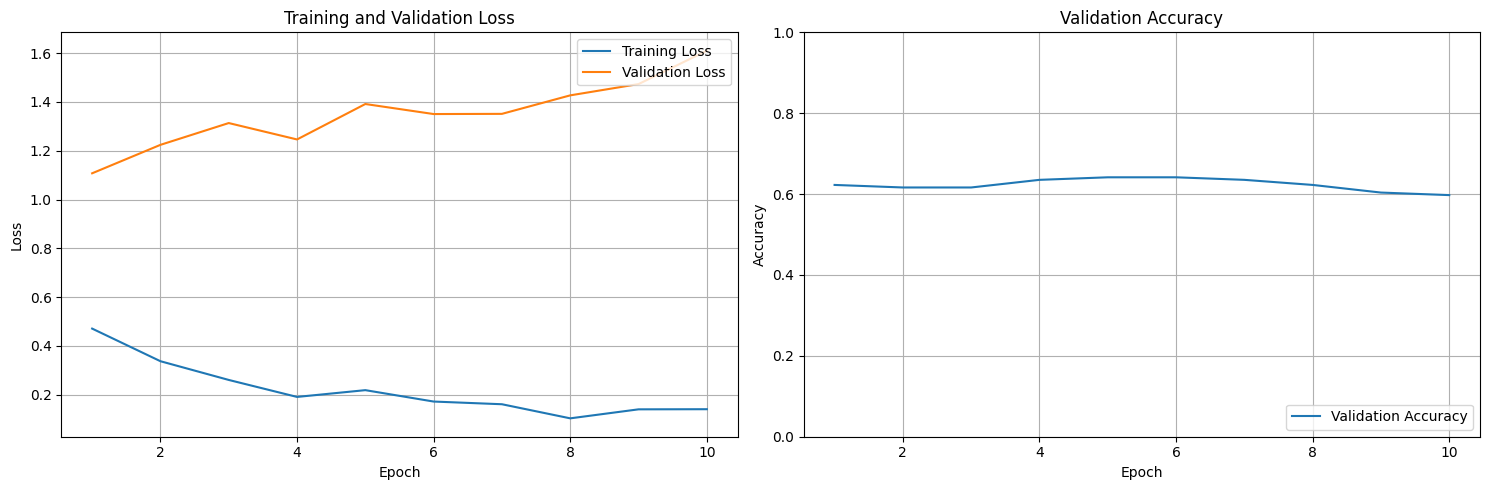

In [ ]:
import matplotlib.pyplot as plt

# Make sure these exist: train_losses, val_losses, val_accuracies

epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(15, 5))

# Plot Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(True)

plt.tight_layout()
plt.show()


Final Evaluation Of The Trained Model Against Test Dataset

In [ ]:
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
from torch.utils.data import DataLoader

test_loader = DataLoader(test_ds, batch_size=8, shuffle=False)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

base_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = base_model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(all_labels, all_preds)
test_precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
test_recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
test_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

print(f"Final Evaluation on Test Set:")
print(f"Accuracy:  {test_accuracy:.2f}")
print(f"Precision: {test_precision:.2f}")
print(f"Recall:    {test_recall:.2f}")
print(f"F1 Score:  {test_f1:.2f}")

Final Evaluation on Test Set:
Accuracy:  0.85
Precision: 0.86
Recall:    0.84
F1 Score:  0.85


Multi-Class Confusion Matrices

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Set model to evaluation mode
base_model.eval()

# Collect predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = base_model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

<Figure size 800x600 with 0 Axes>

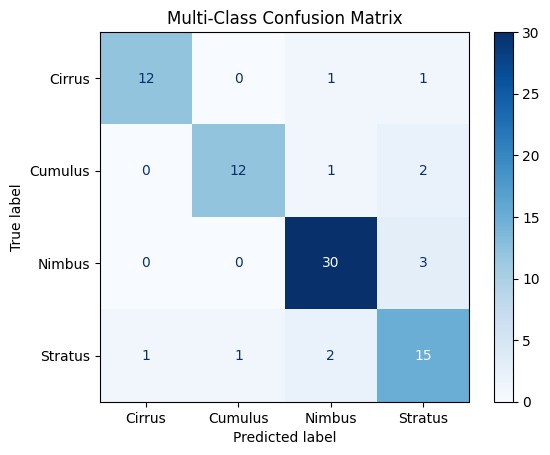

In [ ]:
# Get class names from the underlying ImageFolder
class_names = dataset.dataset.classes

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Multi-Class Confusion Matrix")
plt.show()

**Samples From Predicted Test Dataset**

*   Image
*   Predicted class with its prediction probability
*   Actual Class

In [ ]:
# Assuming `test_ds` from previous cells is the test dataset:
test_dataset = test_ds

print('test size: ', len(test_dataset))


test size:  81


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint

# Define a DataLoader to get images
test_loader = DataLoader(test_ds, batch_size=64, shuffle=True)

# Get one batch of data
image_batch, label_batch = next(iter(test_loader))  # tensors
print('image_batch shape:', image_batch.shape)
print('label_batch shape:', label_batch.shape)
print('First label:', label_batch[0].item())


image_batch shape: torch.Size([64, 3, 128, 128])
label_batch shape: torch.Size([64])
First label: 2


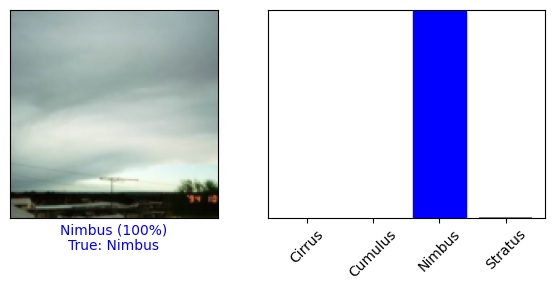

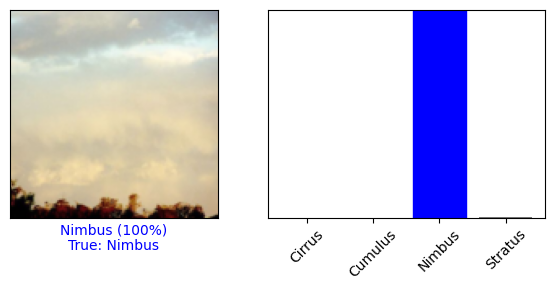

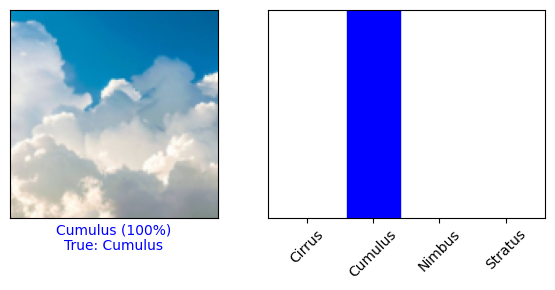

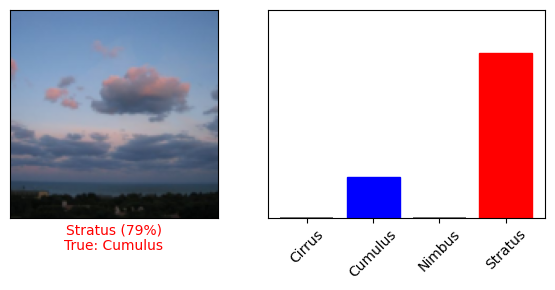

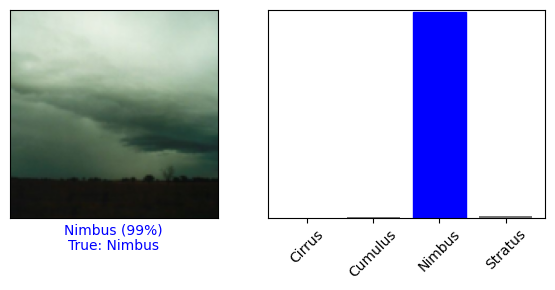

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Make sure the model is in eval mode
base_model.eval()

# Move model to device if not already
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model.to(device)

# Load one batch from test set
test_loader = DataLoader(test_ds, batch_size=8, shuffle=True)
images, true_labels = next(iter(test_loader))
images = images.to(device)

# Get predictions
with torch.no_grad():
    outputs = base_model(images)
    probs = torch.softmax(outputs, dim=1).cpu().numpy()
    preds = np.argmax(probs, axis=1)

# Plot images with predicted and true labels
def plot_prediction(i):
    plt.figure(figsize=(6, 3))

    # Show image
    plt.subplot(1, 2, 1)
    img = images[i].cpu().permute(1, 2, 0).numpy()
    true_label = true_labels[i].item()
    predicted_label = preds[i]
    prob = np.max(probs[i])

    color = "blue" if predicted_label == true_label else "red"
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(f"{class_names[predicted_label]} ({prob:.0%})\nTrue: {class_names[true_label]}", color=color)

    # Show prediction probability bar chart
    plt.subplot(1, 2, 2)
    thisplot = plt.bar(range(num_classes), probs[i], color="#777777")
    plt.ylim([0, 1])
    thisplot[preds[i]].set_color('red')
    thisplot[true_label].set_color('blue')
    plt.xticks(range(num_classes), class_names, rotation=45)
    plt.yticks([])
    plt.tight_layout()
    plt.show()

# Show predictions for first 5 images
for i in range(5):
    plot_prediction(i)


In [ ]:
#!pip install ipywidgets
import ipywidgets as widgets
from IPython.display import display

In [ ]:
# Load all test predictions
all_images = []
all_labels = []
all_preds = []

base_model.eval()
with torch.no_grad():
    for inputs, labels in DataLoader(test_ds, batch_size=32, shuffle=False):
        inputs = inputs.to(device)
        outputs = base_model(inputs)
        preds_batch = outputs.argmax(dim=1).cpu()

        all_images.extend(inputs.cpu())
        all_labels.extend(labels)
        all_preds.extend(preds_batch)

# Convert to tensors
all_images = torch.stack(all_images)
all_labels = torch.tensor(all_labels)
all_preds  = torch.tensor(all_preds)

# Now make the widget for all
def show_image(index):
    image = all_images[index].permute(1, 2, 0).numpy()
    label = all_labels[index].item()
    pred = all_preds[index].item()

    plt.imshow(image)
    plt.title(f'True: {class_names[label]}, Pred: {class_names[pred]}',
              color='blue' if label == pred else 'red')
    plt.axis('off')
    plt.show()

slider = widgets.IntSlider(min=0, max=len(all_images)-1, step=1, description='Image Index:')
display(widgets.interactive(show_image, index=slider))


interactive(children=(IntSlider(value=0, description='Image Index:', max=80), Output()), _dom_classes=('widget…

In [ ]:
# Step 1: Strip widget metadata (remove 'state' that causes nbconvert crash)
import nbformat

notebook_path = "Final_Cloud_Code.ipynb"
clean_path = "Final_Cloud_Code_CLEAN.ipynb"

# Load and clean notebook
with open(notebook_path) as f:
    nb = nbformat.read(f, as_version=4)

# Remove problematic widget metadata
if 'widgets' in nb['metadata']:
    del nb['metadata']['widgets']

# Save cleaned notebook
with open(clean_path, 'w') as f:
    nbformat.write(nb, f)

# Step 2: Convert cleaned notebook to HTML
!jupyter nbconvert --to html "Final_Cloud_Code_CLEAN.ipynb"

# Step 3: Download HTML
from google.colab import files
files.download("Final_Cloud_Code_CLEAN.html")


[NbConvertApp] Converting notebook Final_Cloud_Code_CLEAN.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 9 image(s).
[NbConvertApp] Writing 2599587 bytes to Final_Cloud_Code_CLEAN.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>